Source: https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb

Lecture video: https://course.fast.ai/videos/?lesson=1

# Урок 1 –– Определяем породу домашнего животного

Эта тетрадка рассказывает как построить свой первый классификатор с нуля и добиться выдающейся точности. Погнали!

Все тетрадки начинаются с этих трех строк; они говорят Юпитеру, что нужно автоматически перезагружать модули после изменений в коде, и что картинки и графики следует отображать непосредственно в тетрадке.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Подключаем необхоимые пакеты. На этом уроке мы будем использовать библиотеку [fastai V1](https://www.fast.ai/2018/10/02/fastai-ai/) которая является высокоуровневой оберткой над [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). Fastai содержит множество полезных функций и классов, которые позволяют быстро прототипировать и обучать нейронные сети.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

Если предыдущая ячейка выдала ошибку, то установи библиотеку следующим образом (восклицательный знак говорит Юпитеру, что команду нужно выполнить в терминале):

In [3]:
# If you're using a computer with an unusually small GPU, you may get an out of memory error 
# when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below 
# to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Смотрим на данные

Будем использовать [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) ([kaggle page](https://www.kaggle.com/tanlikesmath/the-oxfordiiit-pet-dataset)) от [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf), который содержит 12 категорий кошек и 25 категорий собак. Нашей модели придется научиться различать эти 37 классов. В их статье указано, что в 2012 они смогли достичь только 59.21% точности (accuracy), используя сложную модель, зависящую от семейства животных, и отдельные модели для головы, туловища и остальной части картинки. Давайте проверим, насколько точную модель можно получить сейчас с помощью Deep Learning.

In [4]:
# We are going to use the `untar_data` function to which we must pass a URL as an argument 
# and which will download and extract the data.
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



Полезные магические-команды Юпитера, для просмотра сигнатуры метода –– `?` и реализации –– `??` (сделай ячейку исполняемой, чтобы посмотреть результат):

Скачиваем датасет из s3-хранилища в amazon:

In [5]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [6]:
path = untar_data(URLs.PETS); path

PosixPath('/home/awecom/.fastai/data/oxford-iiit-pet')

Вот так можно удобно работать с путями, используя `pathlib.Path`:

In [7]:
path.ls()

[PosixPath('/home/awecom/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/awecom/.fastai/data/oxford-iiit-pet/images')]

In [8]:
path_anno = path / 'annotations'
path_img  = path / 'images'

In [9]:
path_anno

PosixPath('/home/awecom/.fastai/data/oxford-iiit-pet/annotations')

Первое, что нужно сделать –– посмотреть на данные. Это важно для понимания задачи. Посмотрим на структуру директорий, метки классов и несколько примеров изображений.

In [10]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/awecom/.fastai/data/oxford-iiit-pet/images/Sphynx_48.jpg'),
 PosixPath('/home/awecom/.fastai/data/oxford-iiit-pet/images/chihuahua_151.jpg'),
 PosixPath('/home/awecom/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_114.jpg'),
 PosixPath('/home/awecom/.fastai/data/oxford-iiit-pet/images/leonberger_104.jpg'),
 PosixPath('/home/awecom/.fastai/data/oxford-iiit-pet/images/great_pyrenees_168.jpg')]

Разные наборы данных хранятся в разном виде. Этот набор загрузим следующим образом (если что-то здесь не понятно –– не страшно):

In [11]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [13]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

Посмотрим на отдельные примеры:

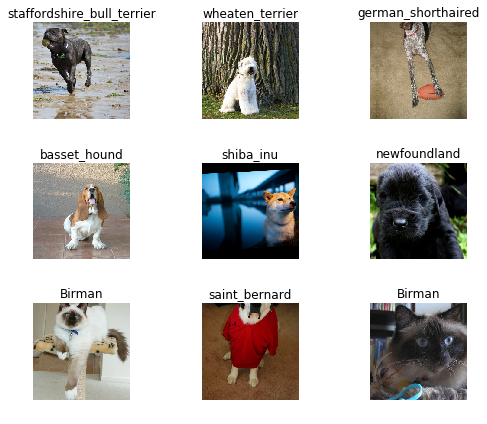

In [14]:
data.show_batch(rows=3, figsize=(7,6))

Метки классов:

In [15]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Training: resnet34

Начнем обучение модели. Будем использовать [сверточную нейросеть](http://cs231n.github.io/convolutional-networks/) в качестве базовой модели и полносвязный классификатор с одним скрытым слоем (позже поговорим об этом подробнее). На данный момент важно понимать, что мы обучаем модель, которая принимает на вход картинку и выдает вероятность для каждой категории (в нашем случае 37 выходов).

Берем предобученную на другой задаче модель:

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Архитектура модели ("структура"). Примерно так выглядело бы создание модели в коде, если бы мы делали это самостоятельно:

In [17]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

Обучаем 4 эпохи (4 прохода по всей выборке)

In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.389227,0.336570,0.101489,00:36
1,0.567367,0.253026,0.088633,00:33
2,0.335389,0.210624,0.067659,00:33
3,0.261232,0.204040,0.066982,00:33


Сохраняем результат

In [20]:
learn.save('stage-1')

## Результаты

Давайте теперь посмотрим на полученные результаты.

Первым делом определим классы, которые модель больше всего путает.

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

Обоснованы ли предсказания модели (или ошибки наивны)?

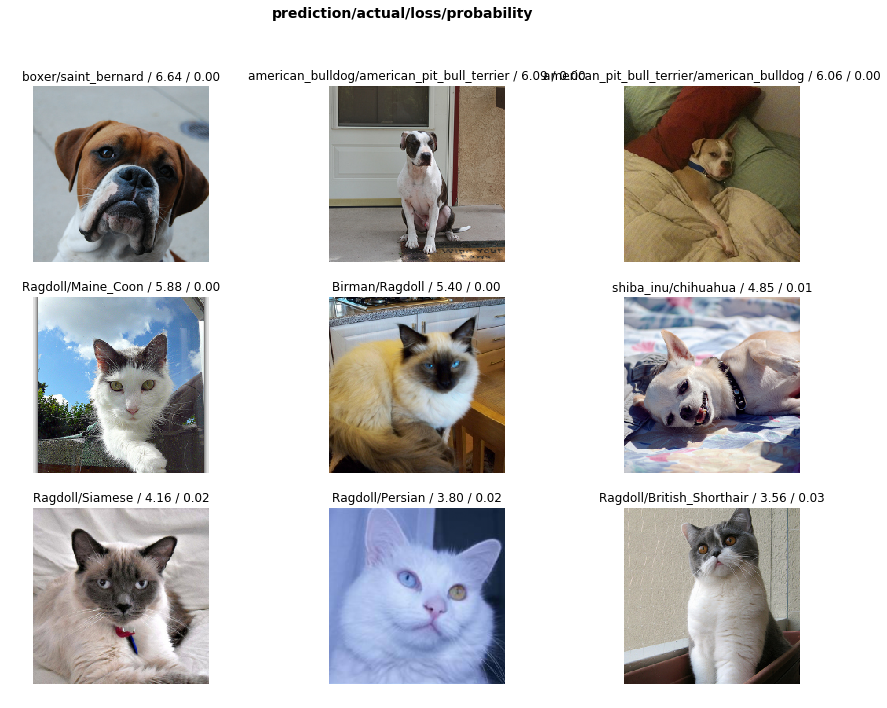

In [22]:
interp.plot_top_losses(9, figsize=(15,11))

В данном случае все предсказания обоснованы сложностью и неоднозначностью примеров. Это индикатор того, что модель работает корректно.

In [23]:
doc(interp.plot_top_losses)

_cl_int_plot_top_losses [source] [test] _cl_int_plot_top_losses ( k , largest = True , figsize = (12, 12) , heatmap : bool = False , heatmap_thresh : int = 16 , return_fig : bool = None ) → Optional [ Figure ] 
 
 × No tests found for _cl_int_plot_top_losses . To contribute a test please refer to this guide and this discussion . Show images in top_losses along with their prediction, actual, loss, and probability of actual class. 
 Show in docs

Чтобы еще точнее проанализировать ошибки, построим матрицу ошибок классификации. Видим, что есть определенные категории, которые модель постоянно путает м/у собой, а другие не путает совсем. Это нормальное поведение, которое означает, что некоторые классы трудно различимы (т.к. породы похожи м/у собой).

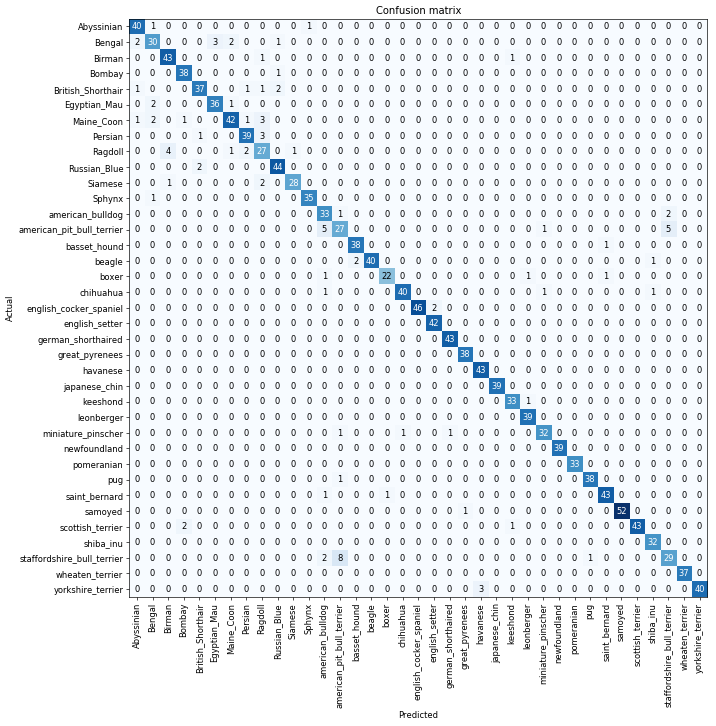

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Список самых трудно-различимых классов:

In [24]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('Bengal', 'Egyptian_Mau', 6),
 ('Egyptian_Mau', 'Bengal', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Maine_Coon', 'Ragdoll', 3),
 ('beagle', 'basset_hound', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('yorkshire_terrier', 'havanese', 3),
 ('British_Shorthair', 'Ragdoll', 2),
 ('Ragdoll', 'Persian', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('beagle', 'saint_bernard', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2)]

## Unfreezing, fine-tuning, and learning rates

Модель работает так, как мы и ожидали. Значит, можно ее разморозить и поучить еще немного.

Изначально мы тренировали только классификатор, а базовая модель (`resnet34`) была заморожена (ее параметры не обновлялись, мы ее использовали "как есть"). Теперь будем обучать всю сеть целиком.

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.488220,0.307835,0.105548,00:45


Что заметили?

Правильно: точность упала. Это произошло потому, что скорость обучения (learning rate) была слишком высока и модель в ходе оптимизации выскочила из одного локального минимума и провалилась в другой (менее оптимальный).

Загрузим предыдущую версию:

In [ ]:
learn.load('stage-1');

Запускаем алгоритм поиска оптимальной скорости обучения:

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


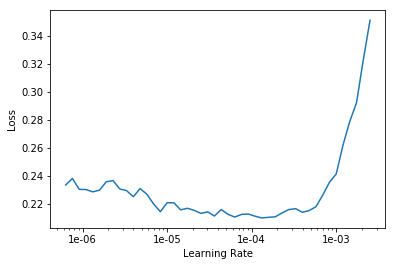

In [31]:
learn.recorder.plot()

Судя по графику, выбираем `lr=1e-6` и постепенно повышаем его до `lr=1e-4`, затем опять снижаем до `lr=1e-6` (one cycle policy) –– на порядок меньше того значения, где значение функции потерь (loss) стало резко расти. Функции потерь говорит насколько сильно ошибается алгоритм.

In [32]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.216516,0.199203,0.069012,00:45
1,0.205414,0.193623,0.066306,00:46


That's a pretty accurate model!

## Training: resnet50

Теперь вместо resnet34 будем использовать resnet50, это похожая сеть, которая отличается только количеством слоев (34 и 50), т.е. она глубже (has higher capacity, "может запомнить больше статистики"). Так же увеличим размер изображений, чтобы дать сети больше деталей. Соответсвенно уменьшим batch size, чтобы картинки поместились в память GPU.

In [29]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [30]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


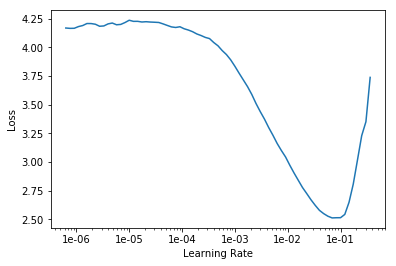

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.734785,0.275880,0.081867,02:10
1,0.384866,0.303205,0.100812,02:05
2,0.337779,0.218687,0.071042,02:04
3,0.277680,0.202640,0.063599,02:04
4,0.197525,0.191171,0.061570,02:05
5,0.139317,0.169229,0.058863,02:05
6,0.105446,0.166869,0.058863,02:04
7,0.082070,0.160484,0.052774,02:04


In [33]:
learn.save('stage-1-50')

Fine tuning:

In [34]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.092508,0.165480,0.049391,02:47
1,0.098785,0.170056,0.054127,02:42
2,0.066652,0.163132,0.052774,02:42


Если fine-tuning не помог, всегда можно вернуться к предыдущей версии.

In [35]:
learn.load('stage-1-50');

In [36]:
interp = ClassificationInterpretation.from_learner(learn)

In [37]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Egyptian_Mau', 'Bengal', 4),
 ('staffordshire_bull_terrier', 'american_bulldog', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Ragdoll', 'Birman', 3),
 ('american_bulldog', 'american_pit_bull_terrier', 3),
 ('Birman', 'Persian', 2),
 ('Birman', 'Siamese', 2),
 ('Bombay', 'scottish_terrier', 2),
 ('basset_hound', 'beagle', 2),
 ('beagle', 'basset_hound', 2),
 ('chihuahua', 'miniature_pinscher', 2)]

## Другие форматы данных

Возможно эти примеры пригодяться для вашего проекта.

In [38]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/awecom/.fastai/data/mnist_sample')

In [39]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

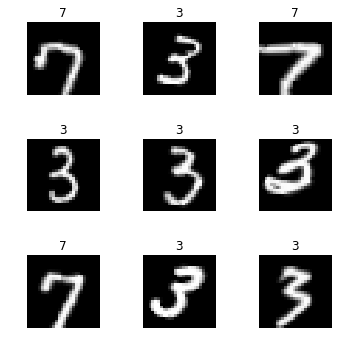

In [40]:
data.show_batch(rows=3, figsize=(5,5))

In [41]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.174670,0.076741,0.976938,00:08
1,0.092140,0.042678,0.989696,00:05


In [42]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [43]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

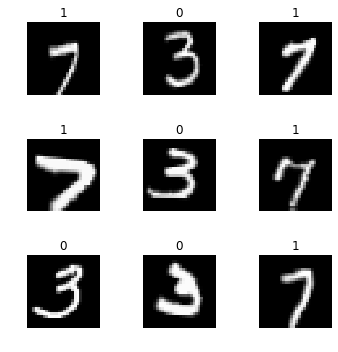

In [44]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [45]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [46]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/awecom/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/awecom/.fastai/data/mnist_sample/train/3/21102.png')]

In [47]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [48]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [49]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [50]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']